# EEG Classification using Conv-LSTM model
Here we do hyperparameter grid search by making own GridSearch object and without using library functions or objects (such as GridSearchCV from sklearn). We need to create such an object, because it is not correct to compare neural networks by scores after a fixed number of epochs (due to overfiting and so on) and we need to plot learning curves.

In [1]:
import os
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, Dropout
from keras.optimizers import RMSprop
from keras.callbacks import Callback, ProgbarLogger, BaseLogger
from keras import backend as K
from keras.regularizers import l1_l2

from src import data as dt

/home/moskaleona/anaconda2/envs/tfcpu/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
path_to_data = '/home/moskaleona/alenadir/data/rawData' #'C:/Users/alena/Desktop/homed/laba/data/rawData' 

In [3]:
data = dt.DataBuildClassifier(path_to_data).get_data([25, 33], shuffle=True, random_state=1, resample_to=128, windows=[(0.2, 0.5)],baseline_window=(0.2, 0.3))

In [4]:
from sklearn.model_selection import train_test_split
X, y = data[33][0], data[33][1]
X_train, X_val, y_train, y_val = train_test_split(data[33][0], data[33][1], test_size=0.2, stratify=data[33][1], random_state=108)

In [36]:
from sklearn.metrics import roc_auc_score, roc_curve
import logging

class LossMetricHistory(Callback):
    def __init__(self, n_iter, validation_data=(None,None), verbose=1):
        super(LossMetricHistory, self).__init__()
        self.n_iter = n_iter
        self.x_val, self.y_val = validation_data
        if self.x_val is not None and self.y_val is not None:
            self.validate = True
        else:
            self.validate = False
        self.verbose = verbose
        
        self.logger = logging.getLogger(self.__class__.__name__)
        self.logger.setLevel(logging.INFO)
        console = logging.StreamHandler()
        console.setLevel(logging.INFO)
        formatter = logging.Formatter("%(message)s")
        console.setFormatter(formatter)
        if len(self.logger.handlers) > 0:
            self.logger.handlers = []
        self.logger.addHandler(console)
            
    
    def on_train_begin(self, logs={}):
        if self.verbose > 0:
            self.logger.info("Training began")
        self.losses = []
        self.val_losses = []
        self.accs = [] # accuracy scores
        self.val_accs = [] # validation accuracy scores
        self.aucs = []# validation ROC AUC scores
        self.sens = []# validation sensitivity (or True Positive Rate) scores
        self.spc = [] # validation specificity scores
        self.thresholds = [] # Decreasing thresholds used to compute specificity and sensitivity
    
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accs.append(logs.get('acc'))
        if self.validate: 
            self.val_losses.append(logs.get('val_loss'))
            self.val_accs.append(logs.get('val_acc'))
            self.y_pred = self.model.predict_proba(self.x_val, verbose=0)
            self.aucs.append(roc_auc_score(self.y_val, self.y_pred))
            
            FPR, TPR, thresholds = roc_curve(self.y_val, self.y_pred)
            self.sens.append(TPR)
            self.spc.append(1-FPR)
            self.thresholds.append(thresholds)
            
            if self.verbose > 0:
                self.logger.info("Epoch %d/%d: train loss = %.6f, test loss = %.6f"%(epoch+1, self.n_iter, 
                                                                    self.losses[-1],self.val_losses[-1]) + 
                                 "\n\tacc = %.6f, test acc = %.6f"%(self.accs[-1], self.val_accs[-1]) +
                                 "\n\tauc = %.6f"%(self.aucs[-1]))
        elif self.verbose > 0:
            self.logger.info("Epoch %d/%d results: train loss = %.6f"%(epoch+1, self.n_iter, self.losses[-1]) + 
                             "\n\t\t\tacc = %.6f"%(self.accs[-1]))
    def on_train_end(self, logs={}):
        self.losses = np.array(self.losses)
        if self.validate:
            self.val_losses = np.array(self.val_losses)
            self.scores = {}
            self.scores['auc'] = np.array(self.aucs)
            self.scores['acc'] = np.array(self.val_accs)
            self.scores['sens'] = np.array(self.sens)
            self.scores['spc'] = np.array(self.spc)
        

In [55]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin
class CnnLstmClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, loss='binary_crossentropy', n_filters=10, n_lstm=30, n_iter=150, batch_size=10,
                 learning_rate=0.001, l1=0., l2=0.0, dropout=0., dropout_lstm=0., recurrent_dropout=0., threshold=0.5):
        self.loss = loss
        self.n_lstm = n_lstm
        self.n_filters = n_filters
        self.n_iter = n_iter
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.l1 = l1
        self.l2 = l2
        self.dropout = dropout
        self.dropout_lstm = dropout_lstm
        self.recurrent_dropout = recurrent_dropout
        self.threshold = threshold
        
    def _make_model(self, input_shape):
        batch_input_shape = (None, input_shape[1], input_shape[2])
        self.model = Sequential()
        self.model.add(Conv1D(self.n_filters, self.kernel_size_, batch_input_shape=batch_input_shape,
                         activation='relu', kernel_regularizer=l1_l2(self.l1, self.l2)))
        self.model.add(Dropout(self.dropout))
        self.model.add(LSTM(self.n_lstm,
                       dropout=self.dropout_lstm, recurrent_dropout=self.recurrent_dropout))
        self.model.add(Dense(1, activation='sigmoid'))
        
    def _plot_loss(self):
        plt.title('Learning curves')
        plt.xlabel('epoch')
        plt.plot(np.arange(len(self.log_.losses)),self.log_.losses, color='tab:blue', label='train loss')
        plt.plot(np.arange(len(self.log_.val_losses)),self.log_.val_losses, color='tab:orange', label='test loss')
        plt.legend()
        plt.show()
    
    def _plot_scores(self,scoring):
        plt.title('Validation '+scoring)
        plt.xlabel('epoch')
        plt.ylabel(scoring)
        plt.plot(np.arange(len(self.log_.aucs)),self.log_.aucs, color='b')
        plt.show()
    
    def fit(self, X_train, y_train, X_val=None, y_val=None, scoring='auc',
            verbose=1, plotcurves=False):
        # TODO: check the parameters
        if verbose > 0:
            print("Training model with parameters:", self.get_params())
        self.kernel_size_ = X_train.shape[2]
        self._make_model(X_train.shape)
        self.optimizer_ = RMSprop(lr=self.learning_rate)
        self.model.compile(loss=self.loss, optimizer=self.optimizer_, metrics=['acc'])
        
        if X_val is not None and y_val is not None:
            self.log_ = LossMetricHistory(n_iter=self.n_iter, 
                                          validation_data=(X_val, y_val), verbose=verbose)
            self.hist_ = self.model.fit(X_train, y_train,
                                        batch_size=self.batch_size,
                                        epochs=self.n_iter, validation_data=(X_val, y_val),
                                        verbose=0, callbacks=[self.log_])
            
            self.best_score_ = self.log_.scores[scoring].max()
            if plotcurves:
                self._plot_loss()
                self._plot_scores(scoring)
        else:
            self.log_ = LossMetricHistory(n_iter=self.n_iter)
            self.hist_ = self.model.fit(X_train, y_train,
                                        batch_size=self.batch_size,
                                        epochs=self.n_iter,
                                        verbose=verbose, callbacks=[self.log_])
        return 
    
    def predict(self, X):
        '''
        try:
            getattr(self, "kernel_size_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
        '''
        proba = self.model.predict(X)
        return (proba > self.threshold).astype('int32')
    
    def predict_proba(self, X):
        '''
        try:
            getattr(self, "kernel_size_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
        '''
        return self.model.predict(X)
    
    
    def score(self, X, y, scoring='auc'):
        try:
            if scoring=='auc':
                return roc_auc_score(y, self.predict_proba(X))
            elif scoring=='acc':
                return accuracy_score(y, self.predict(X))
            else:
                raise ValueError(message="No such option: '%s'. Use 'auc' or 'acc'"%str(scoring))
        except ValueError as err:
            print(err)
    

### Testing that everything is working

('Training model with parameters:', {'loss': 'binary_crossentropy', 'recurrent_dropout': 0.0, 'n_iter': 20, 'learning_rate': 0.001, 'batch_size': 10, 'n_filters': 10, 'l2': 0.0, 'n_lstm': 30, 'l1': 0.0, 'threshold': 0.5, 'dropout_lstm': 0.0, 'dropout': 0.0})


Training began
Epoch 1/20: train loss = 0.697471, test loss = 0.689605
	acc = 0.590517, test acc = 0.623932
	auc = 0.462540
Epoch 2/20: train loss = 0.641786, test loss = 0.681563
	acc = 0.655172, test acc = 0.658120
	auc = 0.479365
Epoch 3/20: train loss = 0.630566, test loss = 0.673736
	acc = 0.657328, test acc = 0.658120
	auc = 0.501905
Epoch 4/20: train loss = 0.613741, test loss = 0.701482
	acc = 0.670259, test acc = 0.649573
	auc = 0.468254
Epoch 5/20: train loss = 0.586095, test loss = 0.709494
	acc = 0.711207, test acc = 0.598291
	auc = 0.468254
Epoch 6/20: train loss = 0.576670, test loss = 0.715513
	acc = 0.721983, test acc = 0.572650
	auc = 0.459683
Epoch 7/20: train loss = 0.568803, test loss = 0.751806
	acc = 0.709052, test acc = 0.623932
	auc = 0.444127
Epoch 8/20: train loss = 0.557746, test loss = 0.728211
	acc = 0.724138, test acc = 0.572650
	auc = 0.468889
Epoch 9/20: train loss = 0.534957, test loss = 0.739108
	acc = 0.745690, test acc = 0.615385
	auc = 0.478095
Epoc

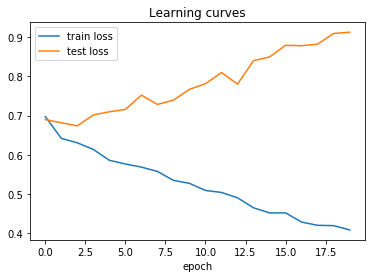

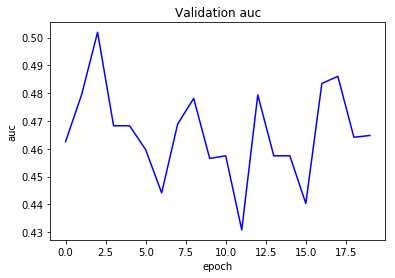

In [56]:
%matplotlib inline
clf = CnnLstmClassifier(n_iter=20)
clf.fit(X_train, y_train, X_val=X_val, y_val=y_val, verbose=1, plotcurves=True)

## Hyperparameter tuning

In [39]:
from sklearn.model_selection import ParameterGrid
from sklearn.base import clone
from functools import reduce

class GridSearch:
    def __init__(self, estimator, param_grid, scoring='auc',
                 cv=None, verbose=0, plot_scores=True, refit=True):
        self.estimator = estimator
        self.param_grid = param_grid
        self.scoring = scoring
        self.cv = cv
        self.verbose = verbose
        self.plot_scores = plot_scores
        self.refit = refit
    
    def _get_param_iterator(self):
        """Return ParameterGrid instance for the given param_grid"""
        return ParameterGrid(self.param_grid)
        
    def fit(self, X, y, groups=None):
        n_splits = cv.get_n_splits(X, y, groups)
        candidate_params = list(self._get_param_iterator())
        n_candidates = len(candidate_params)
        
        if self.verbose > 0:
            print("Fitting {0} folds for each of {1} candidates, totalling"
                  " {2} fits".format(n_splits, n_candidates,
                                     n_candidates * n_splits))
        
        self.cv_scores_ = []
        for params in candidate_params:
            self.cv_scores_.append([])
            for train, test in cv.split(X, y, groups):
                estimator = clone(self.estimator)
                estimator.set_params(**params)
                estimator.fit(X[train], y[train], X_val=X[test], y_val=y[test],
                              scoring=self.scoring, verbose=self.verbose)
                self.cv_scores_[-1].append(estimator.best_score_)
        self.cv_scores_ = reduce(lambda a,b: np.vstack((np.array(a),np.array(b))), self.cv_scores_)
        self.mean_scores_ = self.cv_scores_.mean(axis=1)
        self.best_score_ = self.cv_scores_.max()
        self.best_mean_score_ = self.mean_scores_.max()
        self.best_ind_ = self.mean_scores_.argmax()
        if self.verbose > 0:
            print("Grid search is almost done.\n"
                  "Best score is %.6f, best mean score is %.6f.\n"
                  "Now the best estimator is training..."%(self.best_score_, self.best_mean_score_))
        self.best_params_ = candidate_params[self.best_ind_]
        if refit:
            self.best_estimator_ = clone(self.estimator).set_params(**self.best_params_)
            self.best_estimator_.fit(X,y)
        return self
        

In [10]:
'''
param_grid = {
    'n_iter' : [100, 200, 300],
    'l1' : [0., 0.2, 0.4, 0.6],
    'l2' : [0., 0.2, 0.4, 0.6],
    'dropout' : [0., 0.2, 0.4, 0.6],
    'dropout_lstm' : [0., 0.2, 0.4, 0.6],
    'recurrent_dropout' : [0., 0.2, 0.4, 0.6],
}
'''
param_grid = {
    'n_iter' : [1,2],
    'l1' : [0., 0.2]
}

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit
model = CnnLstmClassifier()
cv = StratifiedShuffleSplit(n_splits=3, test_size = 0.33, random_state = 108)
gs = GridSearch(model, param_grid, cv=cv, verbose=1)

In [156]:
gs.fit(X, y)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
('Training model with parameters:', {'loss': 'binary_crossentropy', 'recurrent_dropout': 0.0, 'n_iter': 1, 'learning_rate': 0.001, 'batch_size': 10, 'n_filters': 10, 'l2': 0.0, 'n_lstm': 30, 'l1': 0.0, 'threshold': 0.5, 'dropout_lstm': 0.0, 'dropout': 0.0})


Training began
Epoch 1/1: train loss = 0.660301, test loss = 0.667251
	acc = 0.655527, test acc = 0.630208
	auc = 0.528337


('Training model with parameters:', {'loss': 'binary_crossentropy', 'recurrent_dropout': 0.0, 'n_iter': 1, 'learning_rate': 0.001, 'batch_size': 10, 'n_filters': 10, 'l2': 0.0, 'n_lstm': 30, 'l1': 0.0, 'threshold': 0.5, 'dropout_lstm': 0.0, 'dropout': 0.0})


Training began
Epoch 1/1: train loss = 0.669225, test loss = 0.661522
	acc = 0.586118, test acc = 0.614583
	auc = 0.553552


('Training model with parameters:', {'loss': 'binary_crossentropy', 'recurrent_dropout': 0.0, 'n_iter': 1, 'learning_rate': 0.001, 'batch_size': 10, 'n_filters': 10, 'l2': 0.0, 'n_lstm': 30, 'l1': 0.0, 'threshold': 0.5, 'dropout_lstm': 0.0, 'dropout': 0.0})


Training began
Epoch 1/1: train loss = 0.714750, test loss = 0.674064
	acc = 0.542416, test acc = 0.588542
	auc = 0.512666


('Training model with parameters:', {'loss': 'binary_crossentropy', 'recurrent_dropout': 0.0, 'n_iter': 2, 'learning_rate': 0.001, 'batch_size': 10, 'n_filters': 10, 'l2': 0.0, 'n_lstm': 30, 'l1': 0.0, 'threshold': 0.5, 'dropout_lstm': 0.0, 'dropout': 0.0})


Training began
Epoch 1/2: train loss = 0.664372, test loss = 0.645554
	acc = 0.634961, test acc = 0.640625
	auc = 0.574290
Epoch 2/2: train loss = 0.643544, test loss = 0.653078
	acc = 0.650386, test acc = 0.630208
	auc = 0.556734


('Training model with parameters:', {'loss': 'binary_crossentropy', 'recurrent_dropout': 0.0, 'n_iter': 2, 'learning_rate': 0.001, 'batch_size': 10, 'n_filters': 10, 'l2': 0.0, 'n_lstm': 30, 'l1': 0.0, 'threshold': 0.5, 'dropout_lstm': 0.0, 'dropout': 0.0})


Training began
Epoch 1/2: train loss = 0.671275, test loss = 0.670466
	acc = 0.591260, test acc = 0.614583
	auc = 0.508307
Epoch 2/2: train loss = 0.645857, test loss = 0.672191
	acc = 0.632391, test acc = 0.619792
	auc = 0.515966


('Training model with parameters:', {'loss': 'binary_crossentropy', 'recurrent_dropout': 0.0, 'n_iter': 2, 'learning_rate': 0.001, 'batch_size': 10, 'n_filters': 10, 'l2': 0.0, 'n_lstm': 30, 'l1': 0.0, 'threshold': 0.5, 'dropout_lstm': 0.0, 'dropout': 0.0})


Training began
Epoch 1/2: train loss = 0.685627, test loss = 0.699001
	acc = 0.562982, test acc = 0.546875
	auc = 0.452339
Epoch 2/2: train loss = 0.630532, test loss = 0.677315
	acc = 0.650386, test acc = 0.614583
	auc = 0.486273


Grid search is almost done.
Best score is 0.574290, best mean score is 0.531519.
Now the best estimator is training...
<type 'dict'> {'n_iter': 1, 'l1': 0.0}
('Training model with parameters:', {'loss': 'binary_crossentropy', 'recurrent_dropout': 0.0, 'n_iter': 1, 'learning_rate': 0.001, 'batch_size': 10, 'n_filters': 10, 'l2': 0.0, 'n_lstm': 30, 'l1': 0.0, 'threshold': 0.5, 'dropout_lstm': 0.0, 'dropout': 0.0})


Training began


Epoch 1/1
581/581 [==============================] - 7s 12ms/step - loss: 0.6749 - acc: 0.6317


Epoch 1/1 results: train loss = 0.674933
			acc = 0.631670


<__main__.GridSearch instance at 0x7f8c7e7dfd88>

In [157]:
print(gs.best_estimator_)
print(gs.best_params_)
print(gs.best_score_)

CnnLstmClassifier(batch_size=10, dropout=0.0, dropout_lstm=0.0, l1=0.0,
         l2=0.0, learning_rate=0.001, loss='binary_crossentropy',
         n_filters=10, n_iter=1, n_lstm=30, recurrent_dropout=0.0,
         threshold=0.5)
{'n_iter': 1, 'l1': 0.0}
0.5742900907269942


### Progressbar examples
TODO: add a progressbar to fit

In [59]:
import progressbar
import time
bar = progressbar.bar.ProgressBar(maxval=70.0, widgets=[
    'progressbar test: ', # Статический текст
    progressbar.Bar(left='[', marker='=', right=']'), # Прогресс
    progressbar.ETA(),
    progressbar.SimpleProgress(), # Надпись "6 из 10"
]).start()
t = 0.0
while t <= 70.0:
    bar.update(t)
    time.sleep(0.01)
    t += 0.1
bar.finish()

progressbar test: [=================================]Time:  0:00:0770.0 of 70.0


In [35]:
import random
def dynamic_message():
    # Use progressbar.DynamicMessage to keep track of some parameter(s) during
    # your calculations
    widgets = [
        progressbar.Percentage(),
        progressbar.Bar(),
        progressbar.DynamicMessage('losts'),
    ]
    with progressbar.ProgressBar(max_value=100, widgets=widgets) as bar:
        min_so_far = 1
        for i in range(100):
            val = random.random()
            time.sleep(0.1)
            if val < min_so_far:
                min_so_far = val
            bar.update(i, losts=min_so_far)
dynamic_message()

100%|############################################################|losts: 0.0182
